<a href="https://colab.research.google.com/github/LilChucky/comparison-between-dnn-and-cnn-on-mnist/blob/main/evaluatingTransferLearningUsability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# All the libraries
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.metrics import AUC, Accuracy, Precision, Recall
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.attention.multi_head_attention import activation

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import pandas as pd

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 2s 0us/step


In [ ]:
#we are talking about RBG (gray here) images. Normalization is easy
x_train = x_train / 255
x_test = x_test/255

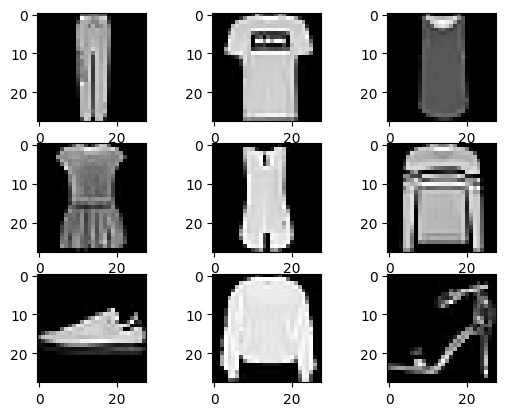

9


In [ ]:
# plot 9 images as gray scale
plt.subplot(331)
plt.imshow(x_train[1000], cmap=plt.get_cmap('gray'))
plt.subplot(332)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(333)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(334)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
plt.subplot(335)
plt.imshow(x_train[4], cmap=plt.get_cmap('gray'))
plt.subplot(336)
plt.imshow(x_train[5], cmap=plt.get_cmap('gray'))
plt.subplot(337)
plt.imshow(x_train[6], cmap=plt.get_cmap('gray'))
plt.subplot(338)
plt.imshow(x_train[7], cmap=plt.get_cmap('gray'))
plt.subplot(339)
plt.imshow(x_train[8], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()
plt.pause(4)
print(y_train[0])

In [ ]:
print('Input data (train) shape is:', x_train.shape)
print('Input data (test) shape is:', x_test.shape)
# print('Input data (validation) shape is:', x_val.shape)

print('Output data (train) shape is:', y_train.shape)
print('Output data (test) shape is:', y_test.shape)
# print('Output data (validation) shape is:', y_val.shape)

print('Train set has the following classes:', np.unique(y_train))
print('Test set has the following classes:', np.unique(y_test))

Input data (train) shape is: (60000, 28, 28)
Input data (test) shape is: (10000, 28, 28)
Output data (train) shape is: (60000,)
Output data (test) shape is: (10000,)
Train set has the following classes: [0 1 2 3 4 5 6 7 8 9]
Test set has the following classes: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
# 5 load previous models
from keras.models import load_model
from google.colab import drive
drive.mount('/content/gdrive')
cNN_transfer = load_model("/content/gdrive/MyDrive/NNarchitectures/cnn.h5")
dNN_transfer = load_model("/content/gdrive/MyDrive/NNarchitectures/dnn.h5")

Mounted at /content/gdrive


In [ ]:
# Defining the same architecture as before
def cNN_from_scratch():
  model = Sequential()
  model.add(keras.Input(shape=(28,28,1)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  return model

In [ ]:
# Again for the deep network
def dNN_from_scratch(predifined_input_dim = 784,\
              predefined_activation_func = 'relu',\
              predifined_activation_map = 'softmax',\
              predifined_output_num = 10 ):
  net = keras.models.Sequential()
  ##addig the hidden layers
  net.add(keras.layers.Dense(12,input_dim = predifined_input_dim,\
                          activation=predefined_activation_func))
  net.add(keras.layers.Dense(8,input_dim = predifined_input_dim,\
                          activation=predefined_activation_func))
  net.add(keras.layers.Dropout(.1, input_shape=(784,) ))
  net.add(keras.layers.Dense(8,input_dim = predifined_input_dim,\
                          activation=predefined_activation_func))
  net.add(keras.layers.Dropout(.1, input_shape=(784,) ))
  net.add(keras.layers.Dense(8,input_dim = predifined_input_dim,\
                          activation=predefined_activation_func))
  #output layer
  net.add(keras.layers.Dense(predifined_output_num,activation=\
                          predifined_activation_map))
  return net

In [ ]:
# The glorious f1 score
def F1Score(precision, recall):
  if(precision+recall==0):
    return 0
  return 2 * (precision * recall) / (precision + recall)

In [ ]:
from keras.layers.attention.multi_head_attention import activation
# Define the K-fold Cross Validator
kfold = KFold(n_splits=6, shuffle=True)

# Define per-fold score containers
cnn_from_scratch_acc_per_fold = []
cnn_from_scratch_loss_per_fold = []
cnn_from_scratch_pre_per_fold = []
cnn_from_scratch_rec_per_fold = []
cnn_from_scratch_auc_per_fold = []
cnn_from_scratch_f1_per_fold = []

cnn_from_scratch_acc_per_fold_test = []
cnn_from_scratch_loss_per_fold_test = []
cnn_from_scratch_pre_per_fold_test = []
cnn_from_scratch_rec_per_fold_test = []
cnn_from_scratch_auc_per_fold_test = []
cnn_from_scratch_f1_per_fold_test = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train, y_train):

  # Define the model architecture

  cNN_from_scratch_model = cNN_from_scratch()

  cNN_from_scratch_model.compile(loss=keras.losses.categorical_crossentropy,\
               optimizer='Adam',\
               metrics=[AUC(), Accuracy(), Precision(), Recall()])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  cnn_history = cNN_from_scratch_model.fit(x_train, y_train, batch_size=125,\
                     validation_split = 0.1,\
                    #  validation_data = (x_val, y_val),\
                     epochs =150)

  # Generate generalization metrics
  CNNscores = cNN_from_scratch_model.evaluate(x_train[train], y_train[train], verbose=0)
  CNNscores_test = cNN_from_scratch_model.evaluate(x_train[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {cNN_from_scratch_model.metrics_names[0]} of {CNNscores[0]}; {cNN_from_scratch_model.metrics_names[1]} of {CNNscores[1]*100}%')
  cnn_from_scratch_acc_per_fold.append(CNNscores[2] * 100)
  cnn_from_scratch_loss_per_fold.append(CNNscores[0])
  cnn_from_scratch_pre_per_fold.append(CNNscores[3])
  cnn_from_scratch_rec_per_fold.append(CNNscores[4])
  cnn_from_scratch_auc_per_fold.append(CNNscores[1])
  cnn_from_scratch_f1_per_fold.append(F1Score(CNNscores[3],CNNscores[4]))

  cnn_from_scratch_acc_per_fold_test.append(CNNscores_test[2] * 100)
  cnn_from_scratch_loss_per_fold_test.append(CNNscores_test[0])
  cnn_from_scratch_pre_per_fold_test.append(CNNscores_test[3])
  cnn_from_scratch_rec_per_fold_test.append(CNNscores_test[4])
  cnn_from_scratch_auc_per_fold_test.append(CNNscores_test[1])
  cnn_from_scratch_f1_per_fold_test.append(F1Score(CNNscores_test[3],CNNscores_test[4]))

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
432/432 [==============================] - 14s 6ms/step - loss: 0.7307 - auc: 0.9696 - accuracy: 8.4815e-04 - precision: 0.8494 - recall: 0.6207 - val_loss: 0.4210 - val_auc: 0.9888 - val_accuracy: 0.0023 - val_precision: 0.8850 - val_recall: 0.8038
Epoch 2/150
432/432 [==============================] - 2s 5ms/step - loss: 0.4464 - auc: 0.9875 - accuracy: 0.0032 - precision: 0.8866 - recall: 0.7887 - val_loss: 0.3463 - val_auc: 0.9922 - val_accuracy: 0.0077 - val_precision: 0.9050 - val_recall: 0.8418
Epoch 3/150
432/432 [==============================] - 3s 7ms/step - loss: 0.3772 - auc: 0.9905 - accuracy: 0.0041 - precision: 0.8991 - recall: 0.8328 - val_loss: 0.3024 - val_auc: 0.9941 - val_accuracy: 0.0046 - val_precision: 0.9162 - val_recall: 0.8642
Epoch 4/150
432/432 [==============================] - 3s 6ms/step - loss: 0.3317 - auc: 0.9924 - accuracy: 0.0053 - precision:

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(cnn_from_scratch_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {cnn_from_scratch_loss_per_fold[i]} - Accuracy: {cnn_from_scratch_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(cnn_from_scratch_acc_per_fold)} (+- {np.std(cnn_from_scratch_acc_per_fold)})')
print(f'> Loss: {np.mean(cnn_from_scratch_loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.05642786994576454 - Accuracy: 32.19040036201477%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.04685748368501663 - Accuracy: 31.96919858455658%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.04759051278233528 - Accuracy: 29.119399189949036%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.04692700132727623 - Accuracy: 27.396199107170105%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.051835350692272186 - Accuracy: 26.366600394248962%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.05275567248463631 - Accuracy: 31.39120042324066%
--------------------------------------------------------------

In [ ]:
results_acc = []
results_pre = []
results_rec = []
results_f1 = []
techniques = []
Set = []
fold = []

In [ ]:
# preparing the dataframe
for i in range(fold_no-1):
  results_acc.append(cnn_from_scratch_acc_per_fold[i])
  results_pre.append(cnn_from_scratch_pre_per_fold[i])
  results_rec.append(cnn_from_scratch_rec_per_fold[i])
  results_f1.append(cnn_from_scratch_f1_per_fold[i])
  techniques.append('CNN_from_scratch')
  Set.append('train')
  fold.append(i)
  results_acc.append(cnn_from_scratch_acc_per_fold_test[i])
  results_pre.append(cnn_from_scratch_pre_per_fold_test[i])
  results_rec.append(cnn_from_scratch_rec_per_fold_test[i])
  results_f1.append(cnn_from_scratch_f1_per_fold_test[i])
  techniques.append('CNN_from_scratch')
  Set.append('test')
  fold.append(i)

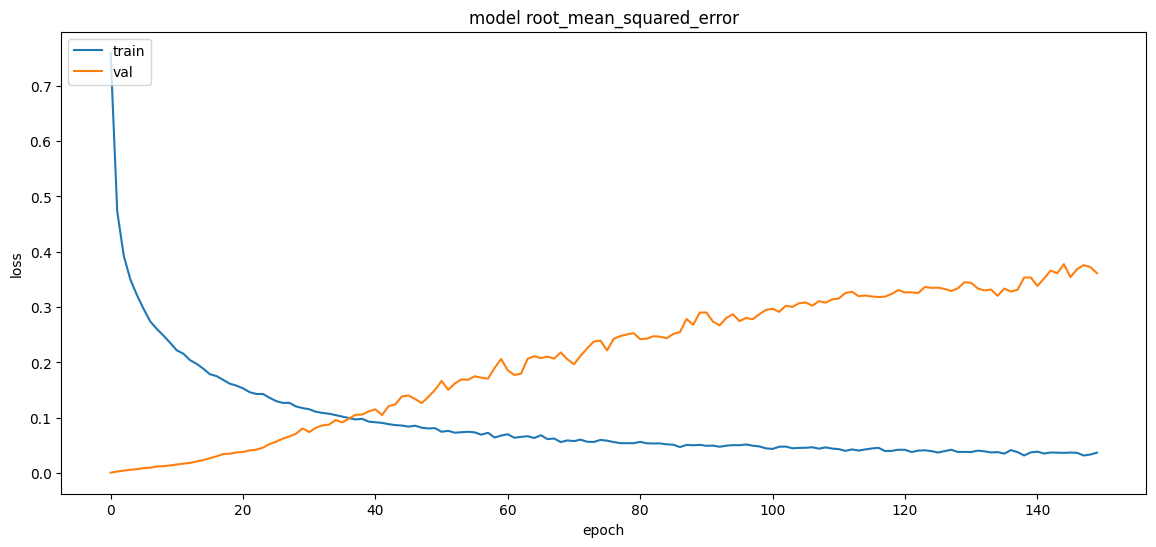

In [ ]:
#1st plot the history performance scores
plt.figure(figsize=(14,6))
plt.plot(cnn_history.history[list(cnn_history.history.keys())[0]])
plt.plot(cnn_history.history[list(cnn_history.history.keys())[2]])
plt.title('model root_mean_squared_error')
plt.ylabel(list(cnn_history.history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for train set
y_train_predictedCNN_from_scratch = cNN_from_scratch_model.predict(x_train)

1875/1875 [==============================] - 3s 2ms/step


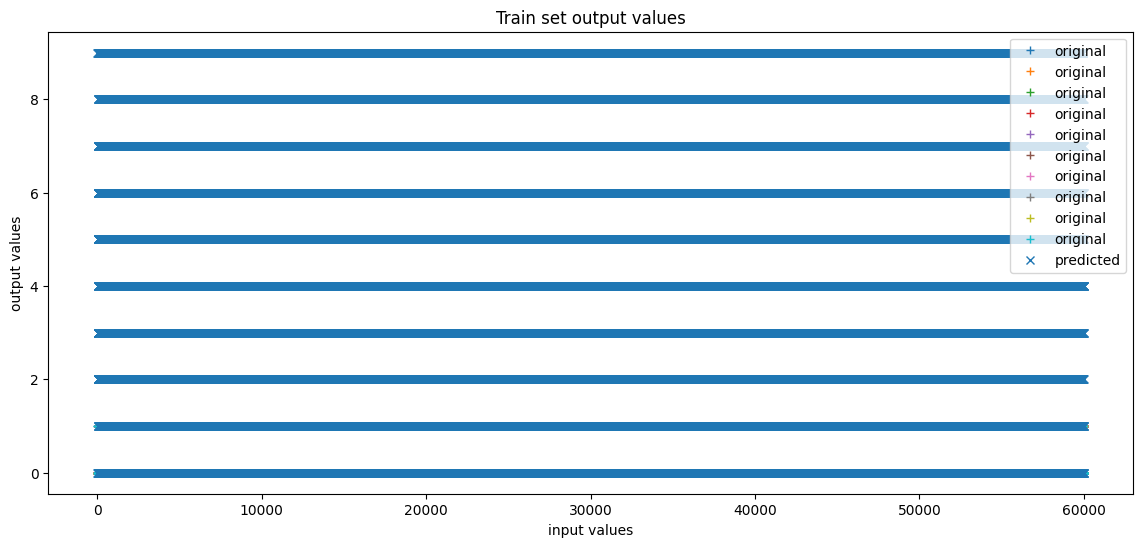

In [ ]:
y_train_predictedCNN_from_scratch = np.argmax(y_train_predictedCNN_from_scratch, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_train, '+', label='original')
plt.plot( y_train_predictedCNN_from_scratch, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for test set
y_test_predictedCNN_from_scratch = cNN_from_scratch_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


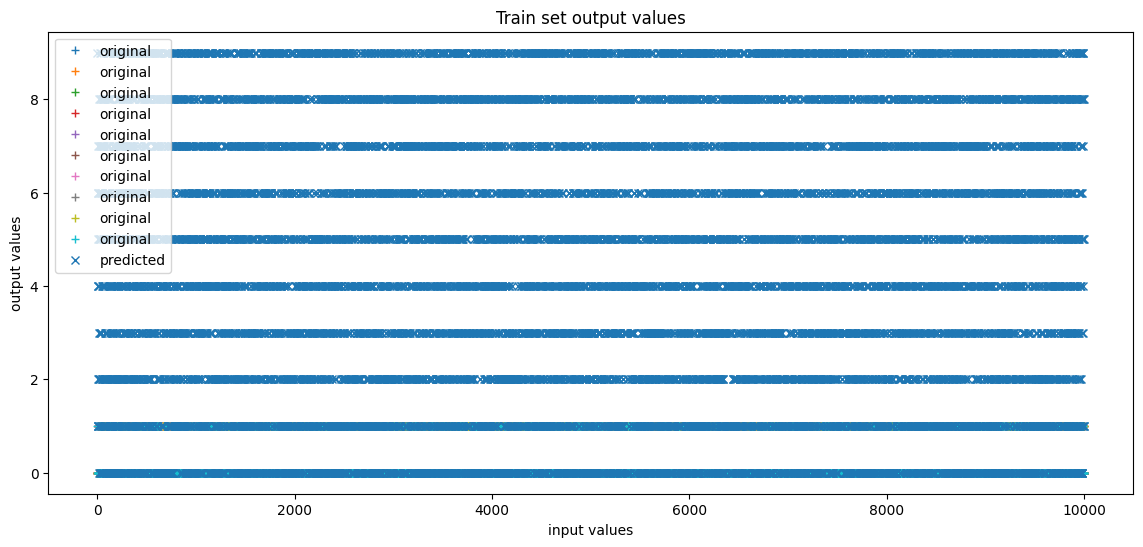

In [ ]:
y_test_predictedCNN_from_scratch = np.argmax(y_test_predictedCNN_from_scratch, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_test, '+', label='original')
plt.plot( y_test_predictedCNN_from_scratch, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#predictions on train
y_train_predictedCNN_from_scratch = to_categorical(y_train_predictedCNN_from_scratch)

accuracy = accuracy_score(y_train, y_train_predictedCNN_from_scratch)
recall = recall_score(y_train, y_train_predictedCNN_from_scratch, average='macro')
precision = precision_score (y_train, y_train_predictedCNN_from_scratch, average='macro')
auc = roc_auc_score(y_train, y_train_predictedCNN_from_scratch)
f1= F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy, " recall:", recall, "precision:", precision, "auc:",auc, "f1:", f1 )

The scores for the predicted outputs are : accuracy: 0.99085  recall: 0.99085 precision: 0.9908520335614905 auc: 0.9949166666666667 f1: 0.9908510167797019


In [ ]:
#Predictions on test
y_test_predictedCNN_from_scratch = to_categorical(y_test_predictedCNN_from_scratch)

accuracy_cnn_test = accuracy_score(y_test, y_test_predictedCNN_from_scratch)
recall_cnn_test = recall_score(y_test, y_test_predictedCNN_from_scratch, average='macro')
precision_cnn_test = precision_score (y_test, y_test_predictedCNN_from_scratch, average='macro')
auc_cnn_test = roc_auc_score(y_test, y_test_predictedCNN_from_scratch)
f1_cnn_test = F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy_cnn_test, " recall:", recall_cnn_test, "precision:", precision_cnn_test, "auc:",auc_cnn_test, "f1:", f1_cnn_test )

The scores for the predicted outputs are : accuracy: 0.9131  recall: 0.9131 precision: 0.9126508386431202 auc: 0.9517222222222224 f1: 0.9908510167797019


In [ ]:
#el Deep network
# Reshaping the data to match the expected inputs of the Dense layers(Trust el plan).
x_train_reshaped = x_train.reshape(60000, x_train.shape[1]*x_train.shape[2])
x_train_reshaped.shape
x_test_reshaped = x_test.reshape(10000, x_test.shape[1]*x_test.shape[2])
x_test_reshaped.shape

(10000, 784)

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=6, shuffle=True)

# Define per-fold score containers
dnn_from_scratch_acc_per_fold = []
dnn_from_scratch_loss_per_fold = []
dnn_from_scratch_pre_per_fold = []
dnn_from_scratch_rec_per_fold = []
dnn_from_scratch_auc_per_fold = []
dnn_from_scratch_f1_per_fold = []

dnn_from_scratch_acc_per_fold_test = []
dnn_from_scratch_loss_per_fold_test = []
dnn_from_scratch_pre_per_fold_test = []
dnn_from_scratch_rec_per_fold_test = []
dnn_from_scratch_auc_per_fold_test = []
dnn_from_scratch_f1_per_fold_test = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train, y_train):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  DNN_from_scratch = dNN_from_scratch()
  DNN_from_scratch.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(),\
                      metrics=[AUC(), Accuracy(), Precision(), Recall()])

  historyDNN = DNN_from_scratch.fit(x_train_reshaped, y_train, batch_size=100,\
                     validation_split = 0.1,\
                    #  validation_data = (x_val, y_val),\
                     epochs =150)

  # Generate generalization metrics
  scoresDNN = DNN_from_scratch.evaluate(x_train_reshaped[train], y_train[train], verbose=0)
  scoresDNN_test = DNN_from_scratch.evaluate(x_train_reshaped[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {DNN_from_scratch.metrics_names[0]} of {scoresDNN[0]}; {DNN_from_scratch.metrics_names[1]} of {scoresDNN[1]*100}%')
  dnn_from_scratch_acc_per_fold.append(scoresDNN[2] * 100)
  dnn_from_scratch_loss_per_fold.append(scoresDNN[0])
  dnn_from_scratch_pre_per_fold.append(scoresDNN[3])
  dnn_from_scratch_rec_per_fold.append(scoresDNN[4])
  dnn_from_scratch_auc_per_fold.append(scoresDNN[1])
  dnn_from_scratch_f1_per_fold.append(F1Score(scoresDNN[3],scoresDNN[4]))

  dnn_from_scratch_acc_per_fold_test.append(scoresDNN_test[2] * 100)
  dnn_from_scratch_loss_per_fold_test.append(scoresDNN_test[0])
  dnn_from_scratch_pre_per_fold_test.append(scoresDNN_test[3])
  dnn_from_scratch_rec_per_fold_test.append(scoresDNN_test[4])
  dnn_from_scratch_auc_per_fold_test.append(scoresDNN_test[1])
  dnn_from_scratch_f1_per_fold_test.append(F1Score(scoresDNN_test[3],scoresDNN_test[4]))

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
540/540 [==============================] - 5s 5ms/step - loss: 1.5008 - auc_6: 0.8710 - accuracy: 0.0000e+00 - precision_6: 0.7877 - recall_6: 0.1705 - val_loss: 0.8383 - val_auc_6: 0.9648 - val_accuracy: 0.0000e+00 - val_precision_6: 0.8856 - val_recall_6: 0.5097
Epoch 2/150
540/540 [==============================] - 2s 4ms/step - loss: 0.9174 - auc_6: 0.9524 - accuracy: 0.0000e+00 - precision_6: 0.8213 - recall_6: 0.4994 - val_loss: 0.6655 - val_auc_6: 0.9761 - val_accuracy: 0.0000e+00 - val_precision_6: 0.9005 - val_recall_6: 0.6637
Epoch 3/150
540/540 [==============================] - 2s 4ms/step - loss: 0.8052 - auc_6: 0.9632 - accuracy: 5.5556e-06 - precision_6: 0.8297 - recall_6: 0.5812 - val_loss: 0.5982 - val_auc_6: 0.9803 - val_accuracy: 0.0000e+00 - val_precision_6: 0.8918 - val_recall_6: 0.7145
Epoch 4/150
540/540 [==============================] - 2s 4ms/step - los

In [ ]:
for i in range(fold_no - 1):
  results_acc.append(dnn_from_scratch_acc_per_fold[i])
  results_pre.append(dnn_from_scratch_pre_per_fold[i])
  results_rec.append(dnn_from_scratch_rec_per_fold[i])
  results_f1.append(dnn_from_scratch_f1_per_fold[i])
  techniques.append('DNN_from_scratch')
  Set.append('train')
  fold.append(i)
  results_acc.append(dnn_from_scratch_acc_per_fold_test[i])
  results_pre.append(dnn_from_scratch_pre_per_fold_test[i])
  results_rec.append(dnn_from_scratch_rec_per_fold_test[i])
  results_f1.append(dnn_from_scratch_f1_per_fold_test[i])
  techniques.append('DNN_from_scratch')
  Set.append('test')
  fold.append(i)

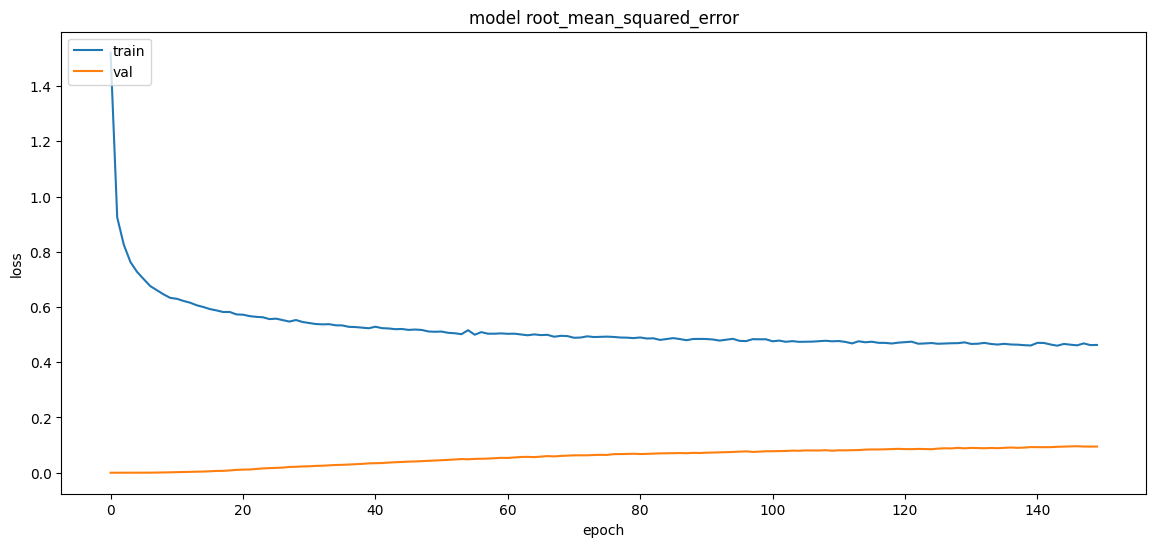

In [ ]:
#1st plot the history performance scores
plt.figure(figsize=(14,6))
plt.plot(historyDNN.history[list(historyDNN.history.keys())[0]])
plt.plot(historyDNN.history[list(historyDNN.history.keys())[2]])
plt.title('model root_mean_squared_error')
plt.ylabel(list(historyDNN.history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for train set
y_train_predictedDNN_from_scratch = DNN_from_scratch.predict(x_train_reshaped)

1875/1875 [==============================] - 3s 2ms/step


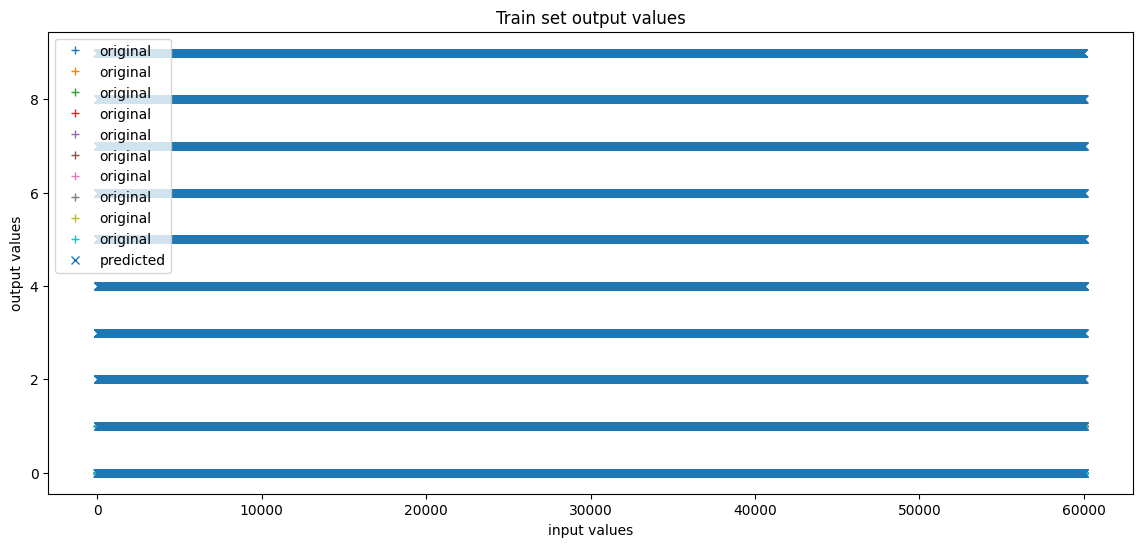

In [ ]:
y_train_predictedDNN_from_scratch = np.argmax(y_train_predictedDNN_from_scratch, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_train, '+', label='original')
plt.plot( y_train_predictedDNN_from_scratch, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for test set
y_test_predictedDNN_from_scratch = DNN_from_scratch.predict(x_test_reshaped)

313/313 [==============================] - 1s 2ms/step


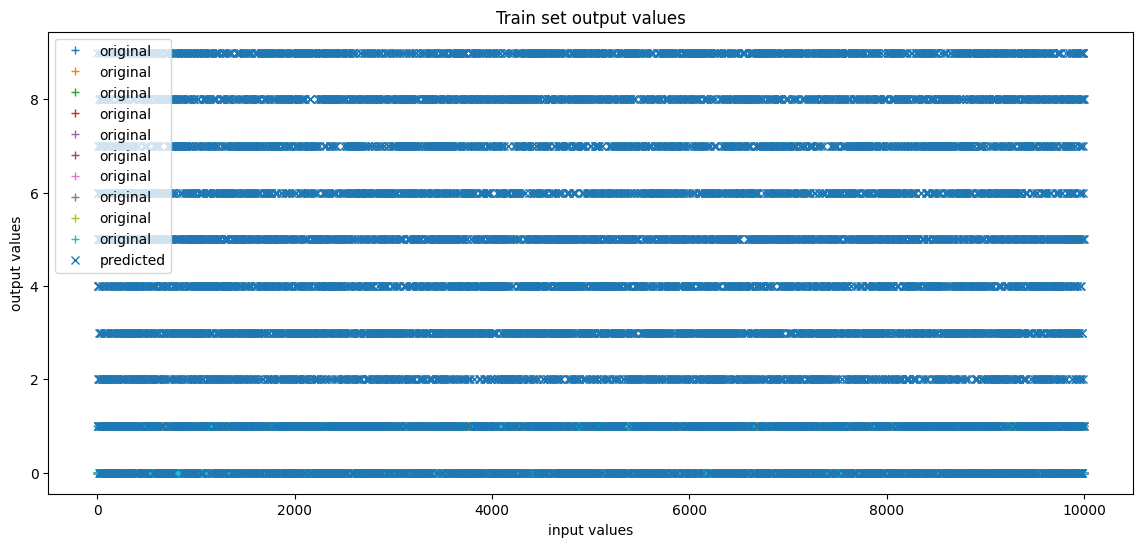

In [ ]:
y_test_predictedDNN_from_scratch = np.argmax(y_test_predictedDNN_from_scratch, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_test, '+', label='original')
plt.plot( y_test_predictedDNN_from_scratch, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#predictions on train
y_train_predictedDNN_from_scratch = to_categorical(y_train_predictedDNN_from_scratch)

accuracy = accuracy_score(y_train, y_train_predictedDNN_from_scratch)
recall = recall_score(y_train, y_train_predictedDNN_from_scratch, average='macro')
precision = precision_score (y_train, y_train_predictedDNN_from_scratch, average='macro')
auc = roc_auc_score(y_train, y_train_predictedDNN_from_scratch)
f1= F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy, " recall:", recall, "precision:", precision, "auc:",auc, "f1:", f1 )

The scores for the predicted outputs are : accuracy: 0.86905  recall: 0.86905 precision: 0.8700308176740416 auc: 0.9272499999999999 f1: 0.8695401322531783


In [ ]:
#Predictions on test
y_test_predictedDNN_from_scratch = to_categorical(y_test_predictedDNN_from_scratch)

accuracy_cnn_test = accuracy_score(y_test, y_test_predictedDNN_from_scratch)
recall_cnn_test = recall_score(y_test, y_test_predictedDNN_from_scratch, average='macro')
precision_cnn_test = precision_score (y_test, y_test_predictedDNN_from_scratch, average='macro')
auc_cnn_test = roc_auc_score(y_test, y_test_predictedDNN_from_scratch)
f1_cnn_test = F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy_cnn_test, " recall:", recall_cnn_test, "precision:", precision_cnn_test, "auc:",auc_cnn_test, "f1:", f1_cnn_test )

The scores for the predicted outputs are : accuracy: 0.8387  recall: 0.8387 precision: 0.8398570657024607 auc: 0.9103888888888889 f1: 0.8695401322531783


In [ ]:
# freeze the models
cNN_transfer.trainable = False
dNN_transfer.trainable = False

In [ ]:
# Creating a new model to encapsulate the frozen tranfered model
dnn_inputs = keras.Input(shape=(784))
y = dNN_transfer(dnn_inputs, training=False)
# y = keras.layers.GlobalAveragePooling2D(784)(y)
dnn_outputs = keras.layers.Dense(10)(y)
# cnn_transfer_model = keras.Model(inputs, outputs)

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=6, shuffle=True)

# Define per-fold score containers
dnn_transfer_frozen_acc_per_fold = []
dnn_transfer_frozen_loss_per_fold = []
dnn_transfer_frozen_auc_per_fold = []
dnn_transfer_frozen_pre_per_fold = []
dnn_transfer_frozen_rec_per_fold = []
dnn_transfer_frozen_f1_per_fold = []

dnn_transfer_frozen_acc_per_fold_test = []
dnn_transfer_frozen_loss_per_fold_test = []
dnn_transfer_frozen_auc_per_fold_test = []
dnn_transfer_frozen_pre_per_fold_test = []
dnn_transfer_frozen_rec_per_fold_test = []
dnn_transfer_frozen_f1_per_fold_test = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train, y_train):

  dnn_transfer_model = keras.Model(dnn_inputs, dnn_outputs)
  dnn_transfer_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=[AUC(), Accuracy(), Precision(), Recall()])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')


  dnn_transfer_history = dnn_transfer_model.fit(x_train_reshaped, y_train, batch_size=125,\
                     validation_split = 0.1,\
                    #  validation_data = (x_val, y_val),\
                     epochs =40)

  # Generate generalization metrics
  DNN_transfer_frozen_scores = dnn_transfer_model.evaluate(x_train_reshaped[train], y_train[train], verbose=0)
  DNN_transfer_frozen_scores_test = dnn_transfer_model.evaluate(x_train_reshaped[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {dnn_transfer_model.metrics_names[0]} of {DNN_transfer_frozen_scores[0]}; {dnn_transfer_model.metrics_names[1]} of {DNN_transfer_frozen_scores[1]*100}%')
  dnn_transfer_frozen_acc_per_fold.append(DNN_transfer_frozen_scores[1] * 100)
  dnn_transfer_frozen_loss_per_fold.append(DNN_transfer_frozen_scores[0])
  dnn_transfer_frozen_auc_per_fold.append(DNN_transfer_frozen_scores[1])
  dnn_transfer_frozen_pre_per_fold.append(DNN_transfer_frozen_scores[3])
  dnn_transfer_frozen_rec_per_fold.append(DNN_transfer_frozen_scores[4])
  dnn_transfer_frozen_f1_per_fold.append(F1Score(DNN_transfer_frozen_scores[3],DNN_transfer_frozen_scores[4]))

  dnn_transfer_frozen_acc_per_fold_test.append(DNN_transfer_frozen_scores_test[1] * 100)
  dnn_transfer_frozen_loss_per_fold_test.append(DNN_transfer_frozen_scores_test[0])
  dnn_transfer_frozen_auc_per_fold_test.append(DNN_transfer_frozen_scores_test[1])
  dnn_transfer_frozen_pre_per_fold_test.append(DNN_transfer_frozen_scores_test[3])
  dnn_transfer_frozen_rec_per_fold_test.append(DNN_transfer_frozen_scores_test[4])
  dnn_transfer_frozen_f1_per_fold_test.append(F1Score(DNN_transfer_frozen_scores_test[3],DNN_transfer_frozen_scores_test[4]))

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
432/432 [==============================] - 3s 4ms/step - loss: 8.1551 - auc_12: 0.4880 - accuracy: 0.0000e+00 - precision_12: 0.0641 - recall_12: 0.0026 - val_loss: 8.8021 - val_auc_12: 0.5058 - val_accuracy: 0.0000e+00 - val_precision_12: 0.0306 - val_recall_12: 0.0012
Epoch 2/40
432/432 [==============================] - 2s 5ms/step - loss: 8.4493 - auc_12: 0.4953 - accuracy: 0.0000e+00 - precision_12: 0.0142 - recall_12: 6.4815e-04 - val_loss: 8.3540 - val_auc_12: 0.4860 - val_accuracy: 0.0000e+00 - val_precision_12: 0.0351 - val_recall_12: 0.0017
Epoch 3/40
432/432 [==============================] - 2s 4ms/step - loss: nan - auc_12: 0.4867 - accuracy: 0.0000e+00 - precision_12: 0.0170 - recall_12: 7.7778e-04 - val_loss: nan - val_auc_12: 0.5000 - val_accuracy: 0.0000e+00 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 4/40
432/432 [===========================

In [ ]:
for i in range(fold_no-1):
  results_acc.append(dnn_transfer_frozen_acc_per_fold[i])
  results_pre.append(dnn_transfer_frozen_pre_per_fold[i])
  results_rec.append(dnn_transfer_frozen_rec_per_fold[i])
  results_f1.append(dnn_transfer_frozen_f1_per_fold[i])
  techniques.append('DNN_transfer')
  Set.append('train')
  fold.append(i)
  results_acc.append(dnn_transfer_frozen_acc_per_fold_test[i])
  results_pre.append(dnn_transfer_frozen_pre_per_fold_test[i])
  results_rec.append(dnn_transfer_frozen_rec_per_fold_test[i])
  results_f1.append(dnn_transfer_frozen_f1_per_fold_test[i])
  techniques.append('DNN_transfer')
  Set.append('test')
  fold.append(i)

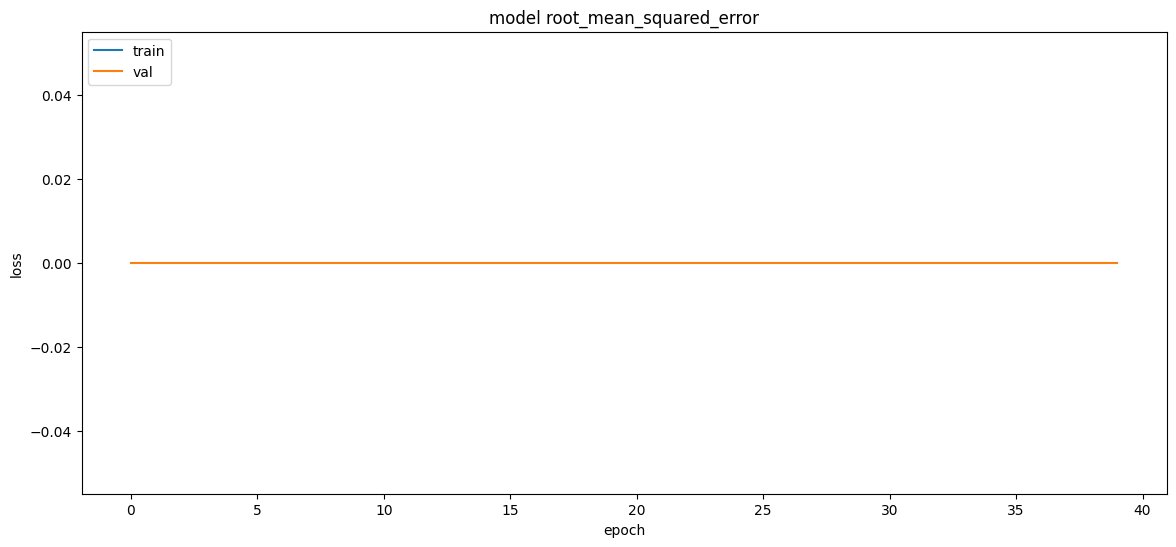

In [ ]:
#1st plot the history performance scores
plt.figure(figsize=(14,6))
plt.plot(dnn_transfer_history.history[list(dnn_transfer_history.history.keys())[0]])
plt.plot(dnn_transfer_history.history[list(dnn_transfer_history.history.keys())[2]])
plt.title('model root_mean_squared_error')
plt.ylabel(list(dnn_transfer_history.history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for train set
y_train_predictedDNN_transfer = dnn_transfer_model.predict(x_train_reshaped)

1875/1875 [==============================] - 3s 2ms/step


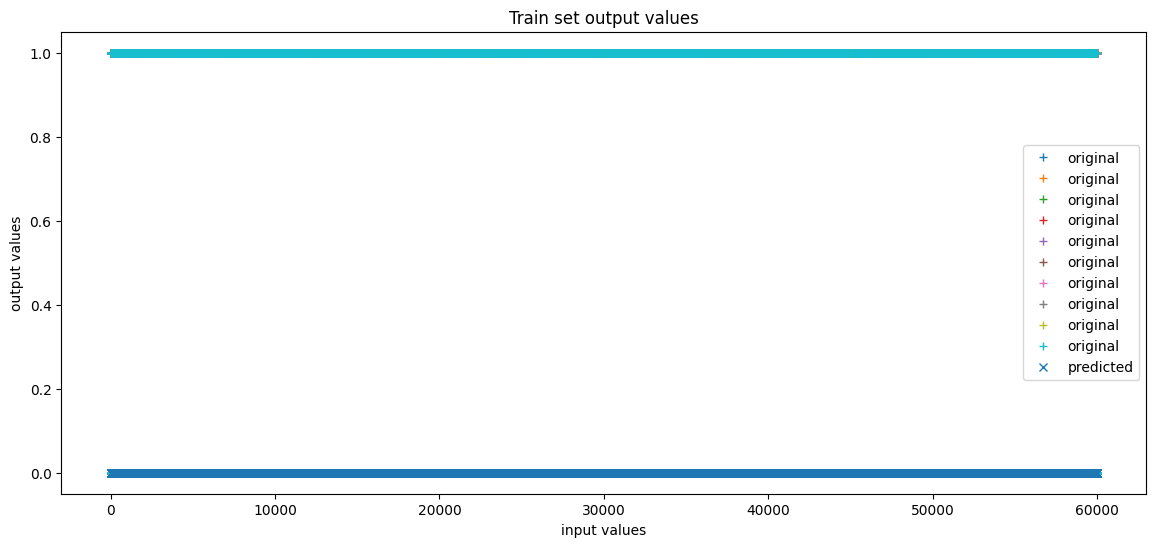

In [ ]:
y_train_predictedDNN_transfer = np.argmax(y_train_predictedDNN_transfer, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_train, '+', label='original')
plt.plot( y_train_predictedDNN_transfer, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for test set
y_test_predictedDNN_transfer = dnn_transfer_model.predict(x_test_reshaped)

313/313 [==============================] - 1s 2ms/step


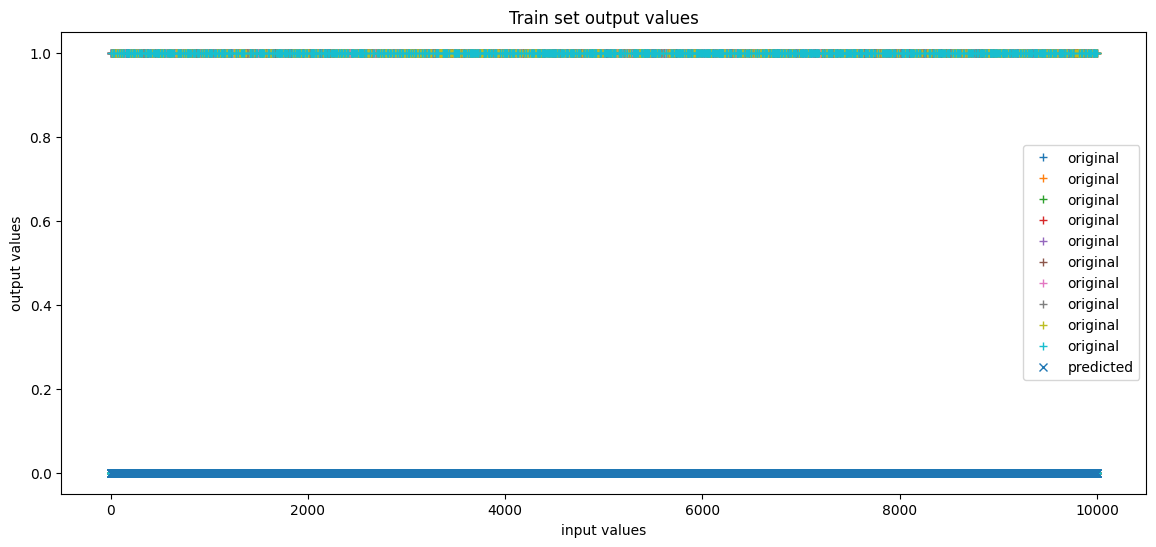

In [ ]:
y_test_predictedDNN_transfer = np.argmax(y_test_predictedDNN_transfer, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_test, '+', label='original')
plt.plot( y_test_predictedDNN_transfer, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#predictions on train
y_train_predictedDNN_transfer = to_categorical(y_train_predictedDNN_transfer)

accuracy = accuracy_score(y_train, y_train_predictedDNN_transfer)
recall = recall_score(y_train, y_train_predictedDNN_transfer, average='macro')
precision = precision_score (y_train, y_train_predictedDNN_transfer, average='macro')
auc = roc_auc_score(y_train, y_train_predictedDNN_transfer)
f1= F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy, " recall:", recall, "precision:", precision, "auc:",auc, "f1:", f1 )

ValueError: ignored

In [ ]:
y_train_predictedDNN_transfer

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
#Predictions on test
y_test_predictedDNN_transfer = to_categorical(y_test_predictedDNN_transfer)

accuracy_cnn_test = accuracy_score(y_test, y_test_predictedDNN_transfer)
recall_cnn_test = recall_score(y_test, y_test_predictedDNN_transfer, average='macro')
precision_cnn_test = precision_score (y_test, y_test_predictedDNN_transfer, average='macro')
auc_cnn_test = roc_auc_score(y_test, y_test_predictedDNN_transfer)
f1_cnn_test = F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy_cnn_test, " recall:", recall_cnn_test, "precision:", precision_cnn_test, "auc:",auc_cnn_test, "f1:", f1_cnn_test )

ValueError: ignored

In [ ]:
# Creating a new model to encapsulate the frozen tranfered model
cnn_inputs = keras.Input(shape=(28,28,1))
x = cNN_transfer(cnn_inputs, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
cnn_outputs = keras.layers.Dense(10)(x)
# cnn_transfer_model = keras.Model(inputs, outputs)

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=6, shuffle=True)

# Define per-fold score containers
cnn_transfer_frozen_acc_per_fold = []
cnn_transfer_frozen_loss_per_fold = []
cnn_transfer_frozen_auc_per_fold = []
cnn_transfer_frozen_pre_per_fold = []
cnn_transfer_frozen_rec_per_fold = []
cnn_transfer_frozen_f1_per_fold = []

cnn_transfer_frozen_acc_per_fold_test = []
cnn_transfer_frozen_loss_per_fold_test = []
cnn_transfer_frozen_auc_per_fold_test = []
cnn_transfer_frozen_pre_per_fold_test = []
cnn_transfer_frozen_rec_per_fold_test = []
cnn_transfer_frozen_f1_per_fold_test = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train, y_train):

  # Define the model architecture
  cnn_transfer_model = keras.Model(cnn_inputs, cnn_outputs)
  cnn_transfer_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=[AUC(), Accuracy(), Precision(), Recall()])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  cnn_transfer_history = cnn_transfer_model.fit(x_train, y_train, batch_size=125,\
                     validation_split = 0.1,\
                    #  validation_data = (x_val, y_val),\
                     epochs =40)

  # Generate generalization metrics

  CNN_transfer_frozen_scores = cnn_transfer_model.evaluate(x_train[train], y_train[train], verbose=0)
  CNN_transfer_frozen_scores_test = cnn_transfer_model.evaluate(x_train[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {cnn_transfer_model.metrics_names[0]} of {CNN_transfer_frozen_scores[0]}; {cnn_transfer_model.metrics_names[1]} of {CNN_transfer_frozen_scores[1]*100}%')
  cnn_transfer_frozen_acc_per_fold.append(CNN_transfer_frozen_scores[2] * 100)
  cnn_transfer_frozen_loss_per_fold.append(CNN_transfer_frozen_scores[0])
  cnn_transfer_frozen_auc_per_fold.append(CNN_transfer_frozen_scores[1])
  cnn_transfer_frozen_pre_per_fold.append(CNN_transfer_frozen_scores[3])
  cnn_transfer_frozen_rec_per_fold.append(CNN_transfer_frozen_scores[4])
  cnn_transfer_frozen_f1_per_fold.append(F1Score(CNN_transfer_frozen_scores[3],CNN_transfer_frozen_scores[4]))

  cnn_transfer_frozen_acc_per_fold_test.append(CNN_transfer_frozen_scores_test[1] * 100)
  cnn_transfer_frozen_loss_per_fold_test.append(CNN_transfer_frozen_scores_test[0])
  cnn_transfer_frozen_auc_per_fold_test.append(CNN_transfer_frozen_scores_test[1])
  cnn_transfer_frozen_pre_per_fold_test.append(CNN_transfer_frozen_scores_test[3])
  cnn_transfer_frozen_rec_per_fold_test.append(CNN_transfer_frozen_scores_test[4])
  cnn_transfer_frozen_f1_per_fold_test.append(F1Score(CNN_transfer_frozen_scores_test[3],CNN_transfer_frozen_scores_test[4]))


  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
432/432 [==============================] - 4s 6ms/step - loss: 7.9857 - auc_18: 0.5274 - accuracy: 0.0000e+00 - precision_18: 0.0660 - recall_18: 0.0209 - val_loss: 9.4769 - val_auc_18: 0.5222 - val_accuracy: 0.0000e+00 - val_precision_18: 0.0826 - val_recall_18: 0.0373
Epoch 2/40
432/432 [==============================] - 2s 4ms/step - loss: 8.8963 - auc_18: 0.5206 - accuracy: 0.0000e+00 - precision_18: 0.0831 - recall_18: 0.0407 - val_loss: 9.4178 - val_auc_18: 0.5122 - val_accuracy: 0.0000e+00 - val_precision_18: 0.1003 - val_recall_18: 0.0608
Epoch 3/40
432/432 [==============================] - 2s 4ms/step - loss: 8.6481 - auc_18: 0.5163 - accuracy: 0.0000e+00 - precision_18: 0.0894 - recall_18: 0.0623 - val_loss: 9.4816 - val_auc_18: 0.5105 - val_accuracy: 0.0000e+00 - val_precision_18: 0.0842 - val_recall_18: 0.0662
Epoch 4/40
432/432 [==============================] - 2s 

In [ ]:
for i in range(fold_no-1):
  results_acc.append(cnn_transfer_frozen_acc_per_fold[i])
  results_pre.append(cnn_transfer_frozen_pre_per_fold[i])
  results_rec.append(cnn_transfer_frozen_rec_per_fold[i])
  results_f1.append(cnn_transfer_frozen_f1_per_fold[i])
  techniques.append('CNN_transfer')
  Set.append('train')
  fold.append(i)
  results_acc.append(cnn_transfer_frozen_acc_per_fold_test[i])
  results_pre.append(cnn_transfer_frozen_pre_per_fold_test[i])
  results_rec.append(cnn_transfer_frozen_rec_per_fold_test[i])
  results_f1.append(cnn_transfer_frozen_f1_per_fold_test[i])
  techniques.append('CNN_transfer')
  Set.append('test')
  fold.append(i)

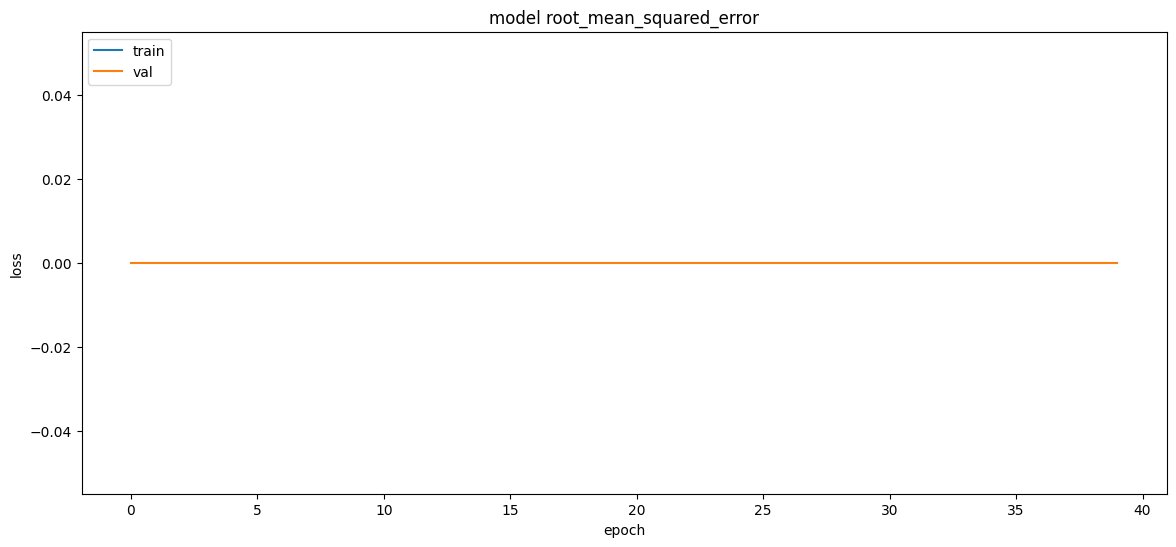

In [ ]:
#1st plot the history performance scores
plt.figure(figsize=(14,6))
plt.plot(cnn_transfer_history.history[list(cnn_transfer_history.history.keys())[0]])
plt.plot(cnn_transfer_history.history[list(cnn_transfer_history.history.keys())[2]])
plt.title('model root_mean_squared_error')
plt.ylabel(list(cnn_transfer_history.history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for train set
y_train_predictedCNN_transfe_frozen = cnn_transfer_model.predict(x_train)

1875/1875 [==============================] - 4s 2ms/step


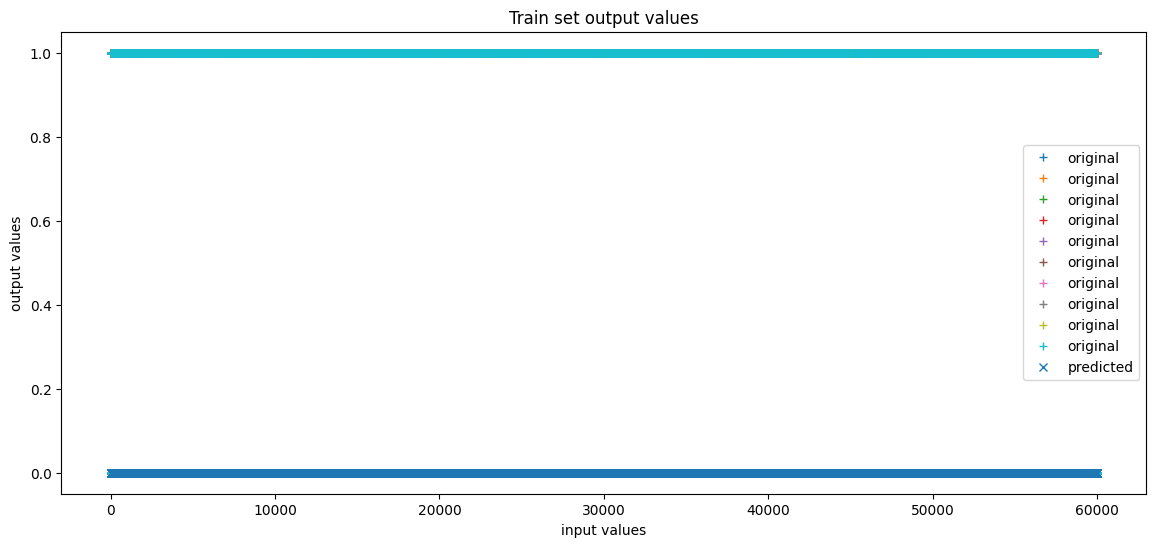

In [ ]:
y_train_predictedCNN_transfe_frozen = np.argmax(y_train_predictedCNN_transfe_frozen, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_train, '+', label='original')
plt.plot( y_train_predictedCNN_transfe_frozen, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for test set
y_test_predictedCNN_transfe_frozen = cnn_transfer_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


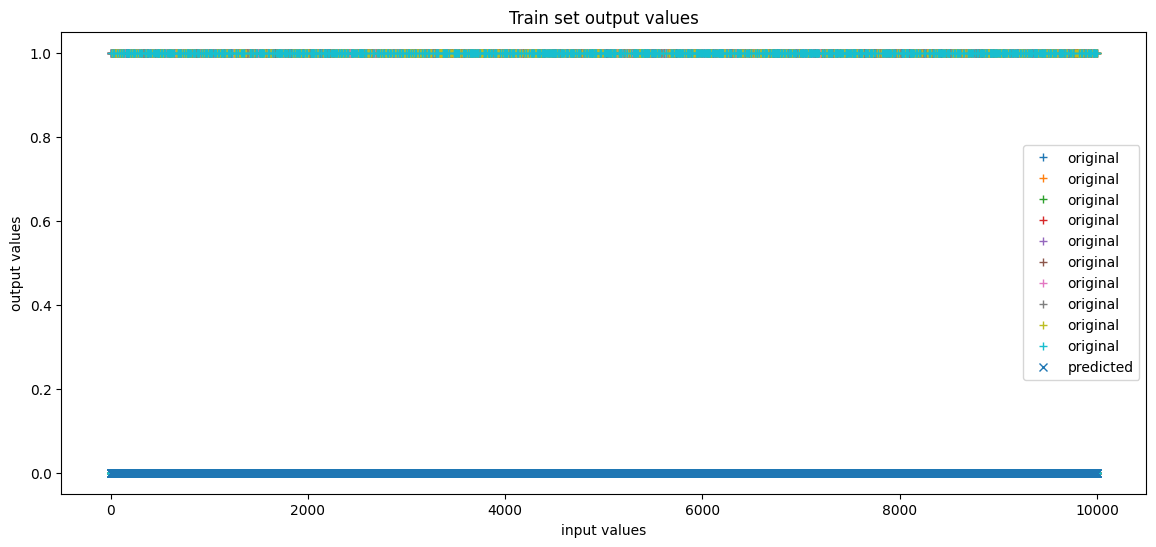

In [ ]:
y_test_predictedCNN_transfe_frozen = np.argmax(y_test_predictedCNN_transfe_frozen, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_test, '+', label='original')
plt.plot( y_test_predictedCNN_transfe_frozen, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#predictions on train
y_train_predictedCNN_transfe_frozen = to_categorical(y_train_predictedCNN_transfe_frozen)

accuracy = accuracy_score(y_train, y_train_predictedCNN_transfe_frozen)
recall = recall_score(y_train, y_train_predictedCNN_transfe_frozen, average='macro')
precision = precision_score (y_train, y_train_predictedCNN_transfe_frozen, average='macro')
auc = roc_auc_score(y_train, y_train_predictedCNN_transfe_frozen)
f1= F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy, " recall:", recall, "precision:", precision, "auc:",auc, "f1:", f1 )

ValueError: ignored

In [ ]:
#Predictions on test
y_test_predictedCNN_transfe_frozen = to_categorical(y_test_predictedCNN_transfe_frozen)

accuracy_cnn_test = accuracy_score(y_test, y_test_predictedCNN_transfe_frozen)
recall_cnn_test = recall_score(y_test, y_test_predictedCNN_transfe_frozen, average='macro')
precision_cnn_test = precision_score (y_test, y_test_predictedCNN_transfe_frozen, average='macro')
auc_cnn_test = roc_auc_score(y_test, y_test_predictedCNN_transfe_frozen)
f1_cnn_test = F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy_cnn_test, " recall:", recall_cnn_test, "precision:", precision_cnn_test, "auc:",auc_cnn_test, "f1:", f1_cnn_test )

In [ ]:
# unfreeze layers and train 20 epochs
cNN_transfer.trainable = True
dNN_transfer.trainable = True

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=6, shuffle=True)

# Define per-fold score containers
dnn_transfer_unfrozen_acc_per_fold = []
dnn_transfer_unfrozen_loss_per_fold = []
dnn_transfer_unfrozen_auc_per_fold = []
dnn_transfer_unfrozen_pre_per_fold = []
dnn_transfer_unfrozen_rec_per_fold = []
dnn_transfer_unfrozen_f1_per_fold = []

dnn_transfer_unfrozen_acc_per_fold_test = []
dnn_transfer_unfrozen_loss_per_fold_test = []
dnn_transfer_unfrozen_auc_per_fold_test = []
dnn_transfer_unfrozen_pre_per_fold_test = []
dnn_transfer_unfrozen_rec_per_fold_test = []
dnn_transfer_unfrozen_f1_per_fold_test = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train, y_train):

  # dnn_transfer_model = keras.Model(dnn_inputs, dnn_outputs)
  dnn_transfer_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=[AUC(), Accuracy(), Precision(), Recall()])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')


  dnn_transfer_history_unfrozen = dnn_transfer_model.fit(x_train_reshaped, y_train, batch_size=125,\
                     validation_split = 0.1,\
                    #  validation_data = (x_val, y_val),\
                     epochs =40)

  # Generate generalization metrics
  DNN_transfer_unfrozen_scores = dnn_transfer_model.evaluate(x_train_reshaped[train], y_train[train], verbose=0)
  DNN_transfer_unfrozen_scores_test = dnn_transfer_model.evaluate(x_train_reshaped[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {dnn_transfer_model.metrics_names[0]} of {DNN_transfer_unfrozen_scores[0]}; {dnn_transfer_model.metrics_names[1]} of {DNN_transfer_unfrozen_scores[1]*100}%')
  dnn_transfer_unfrozen_acc_per_fold.append(DNN_transfer_unfrozen_scores[1] * 100)
  dnn_transfer_unfrozen_loss_per_fold.append(DNN_transfer_unfrozen_scores[0])
  dnn_transfer_unfrozen_auc_per_fold.append(DNN_transfer_unfrozen_scores[1])
  dnn_transfer_unfrozen_pre_per_fold.append(DNN_transfer_unfrozen_scores[3])
  dnn_transfer_unfrozen_rec_per_fold.append(DNN_transfer_unfrozen_scores[4])
  dnn_transfer_unfrozen_f1_per_fold.append(F1Score(DNN_transfer_unfrozen_scores[3],DNN_transfer_unfrozen_scores[4]))

  dnn_transfer_unfrozen_acc_per_fold_test.append(DNN_transfer_unfrozen_scores_test[1] * 100)
  dnn_transfer_unfrozen_loss_per_fold_test.append(DNN_transfer_unfrozen_scores_test[0])
  dnn_transfer_unfrozen_auc_per_fold_test.append(DNN_transfer_unfrozen_scores_test[1])
  dnn_transfer_unfrozen_pre_per_fold_test.append(DNN_transfer_unfrozen_scores_test[3])
  dnn_transfer_unfrozen_rec_per_fold_test.append(DNN_transfer_unfrozen_scores_test[4])
  dnn_transfer_unfrozen_f1_per_fold_test.append(F1Score(DNN_transfer_unfrozen_scores_test[3],DNN_transfer_unfrozen_scores_test[4]))

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
432/432 [==============================] - 5s 5ms/step - loss: nan - auc_24: 0.5000 - accuracy: 0.0000e+00 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_loss: nan - val_auc_24: 0.5000 - val_accuracy: 0.0000e+00 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00
Epoch 2/40
432/432 [==============================] - 2s 4ms/step - loss: nan - auc_24: 0.5000 - accuracy: 0.0000e+00 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_loss: nan - val_auc_24: 0.5000 - val_accuracy: 0.0000e+00 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00
Epoch 3/40
432/432 [==============================] - 2s 4ms/step - loss: nan - auc_24: 0.5000 - accuracy: 0.0000e+00 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_loss: nan - val_auc_24: 0.5000 - val_accuracy: 0.0000e+00 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00
Epoch 4/40
432/432 [=======

In [ ]:
for i in range(fold_no-1):
  results_acc.append(dnn_transfer_unfrozen_acc_per_fold[i])
  results_pre.append(dnn_transfer_unfrozen_pre_per_fold[i])
  results_rec.append(dnn_transfer_unfrozen_rec_per_fold[i])
  results_f1.append(dnn_transfer_unfrozen_f1_per_fold[i])
  techniques.append('DNN_transfer_fine_tuning')
  Set.append('train')
  fold.append(i)
  results_acc.append(dnn_transfer_unfrozen_acc_per_fold_test[i])
  results_pre.append(dnn_transfer_unfrozen_pre_per_fold_test[i])
  results_rec.append(dnn_transfer_unfrozen_rec_per_fold_test[i])
  results_f1.append(dnn_transfer_unfrozen_f1_per_fold_test[i])
  techniques.append('DNN_transfer_fine_tuning')
  Set.append('test')
  fold.append(i)

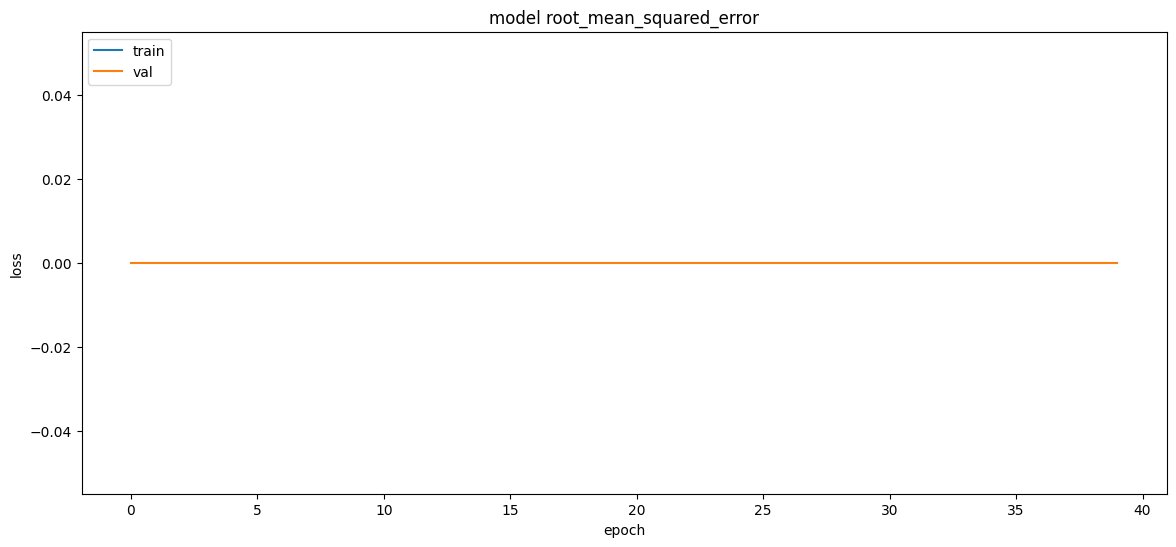

In [ ]:
#1st plot the history performance scores
plt.figure(figsize=(14,6))
plt.plot(dnn_transfer_history_unfrozen.history[list(dnn_transfer_history_unfrozen.history.keys())[0]])
plt.plot(dnn_transfer_history_unfrozen.history[list(dnn_transfer_history_unfrozen.history.keys())[2]])
plt.title('model root_mean_squared_error')
plt.ylabel(list(dnn_transfer_history_unfrozen.history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for train set
y_train_predictedDNN_transfer_history_unfrozen = dnn_transfer_model.predict(x_train_reshaped)

1875/1875 [==============================] - 4s 2ms/step


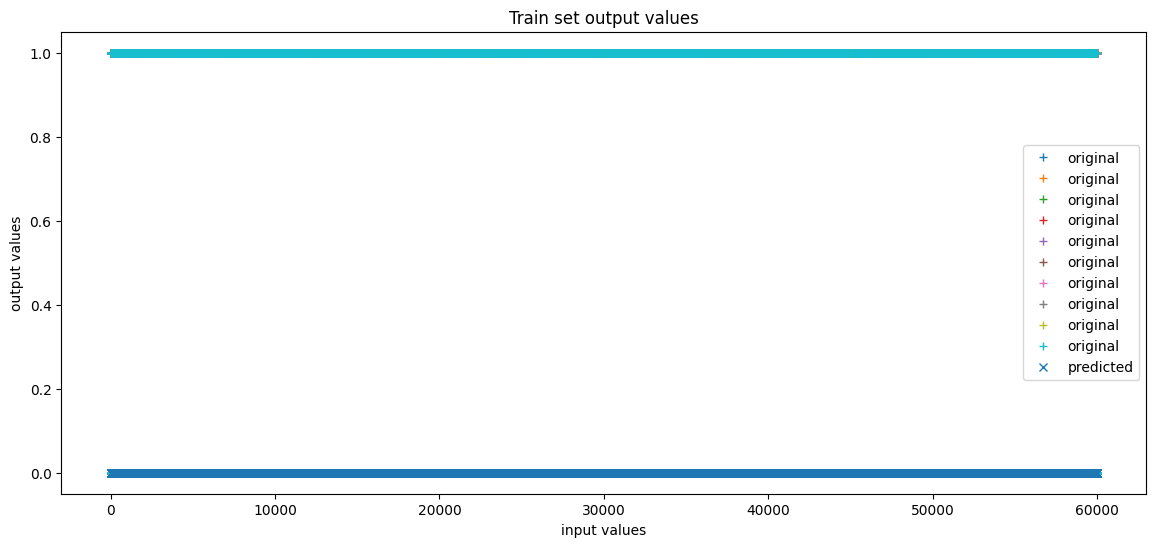

In [ ]:
y_train_predictedDNN_transfer_history_unfrozen = np.argmax(y_train_predictedDNN_transfer_history_unfrozen, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_train, '+', label='original')
plt.plot( y_train_predictedDNN_transfer_history_unfrozen, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for test set
y_test_predictedDNN_transfer_history_unfrozen = dnn_transfer_model.predict(x_test_reshaped)

313/313 [==============================] - 1s 2ms/step


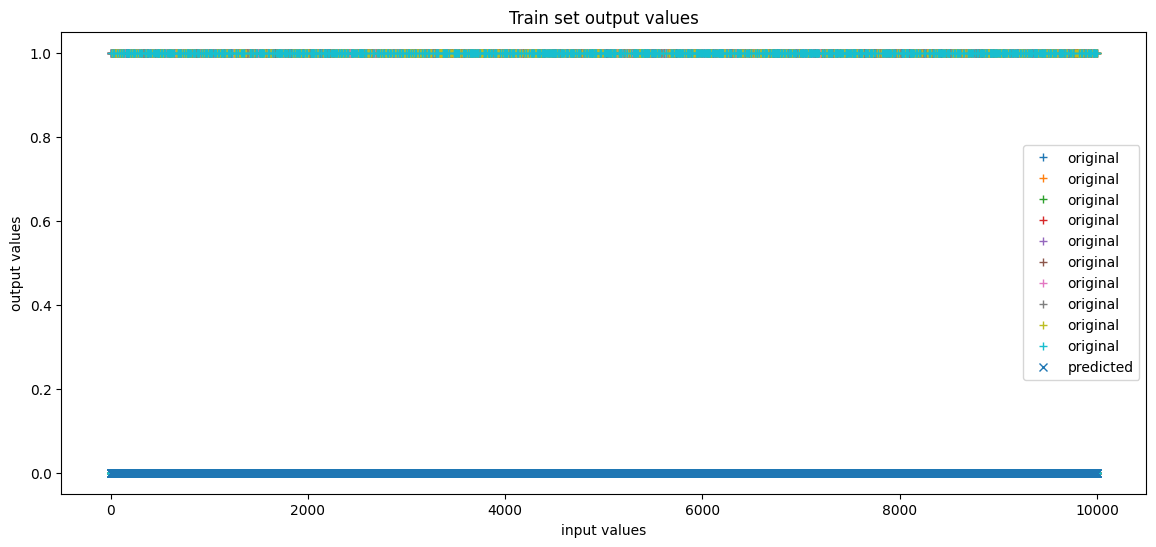

In [ ]:
y_test_predictedDNN_transfer_history_unfrozen = np.argmax(y_test_predictedDNN_transfer_history_unfrozen, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_test, '+', label='original')
plt.plot( y_test_predictedDNN_transfer_history_unfrozen, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#predictions on train
y_train_predictedDNN_transfer_history_unfrozen = to_categorical(y_train_predictedDNN_transfer_history_unfrozen)

accuracy = accuracy_score(y_train, y_train_predictedDNN_transfer_history_unfrozen)
recall = recall_score(y_train, y_train_predictedDNN_transfer_history_unfrozen, average='macro')
precision = precision_score (y_train, y_train_predictedDNN_transfer_history_unfrozen, average='macro')
auc = roc_auc_score(y_train, y_train_predictedDNN_transfer_history_unfrozen)
f1= F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy, " recall:", recall, "precision:", precision, "auc:",auc, "f1:", f1 )

ValueError: ignored

In [ ]:
#Predictions on test
y_test_predictedDNN_transfer_history_unfrozen = to_categorical(y_test_predictedDNN_transfer_history_unfrozen)

accuracy_cnn_test = accuracy_score(y_test, y_test_predictedDNN_transfer_history_unfrozen)
recall_cnn_test = recall_score(y_test, y_test_predictedDNN_transfer_history_unfrozen, average='macro')
precision_cnn_test = precision_score (y_test, y_test_predictedDNN_transfer_history_unfrozen, average='macro')
auc_cnn_test = roc_auc_score(y_test, y_test_predictedDNN_transfer_history_unfrozen)
f1_cnn_test = F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy_cnn_test, " recall:", recall_cnn_test, "precision:", precision_cnn_test, "auc:",auc_cnn_test, "f1:", f1_cnn_test )

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=6, shuffle=True)

# Define per-fold score containers
cnn_transfer_unfrozen_acc_per_fold = []
cnn_transfer_unfrozen_loss_per_fold = []
cnn_transfer_unfrozen_auc_per_fold = []
cnn_transfer_unfrozen_pre_per_fold = []
cnn_transfer_unfrozen_rec_per_fold = []
cnn_transfer_unfrozen_f1_per_fold = []

cnn_transfer_unfrozen_acc_per_fold_test = []
cnn_transfer_unfrozen_loss_per_fold_test = []
cnn_transfer_unfrozen_auc_per_fold_test = []
cnn_transfer_unfrozen_pre_per_fold_test = []
cnn_transfer_unfrozen_rec_per_fold_test = []
cnn_transfer_unfrozen_f1_per_fold_test = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train, y_train):

  # Define the model architecture
  # cnn_transfer_model = keras.Model(cnn_inputs, cnn_outputs)
  cnn_transfer_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=[AUC(), Accuracy(), Precision(), Recall()])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  cnn_unfrozen_transfer_history = cnn_transfer_model.fit(x_train, y_train, batch_size=125,\
                     validation_split = 0.1,\
                    #  validation_data = (x_val, y_val),\
                     epochs =20)

  # Generate generalization metrics
  CNN_transfer_unfrozen_scores = cnn_transfer_model.evaluate(x_train[train], y_train[train], verbose=0)
  CNN_transfer_unfrozen_scores_test = cnn_transfer_model.evaluate(x_train[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {cnn_transfer_model.metrics_names[0]} of {CNN_transfer_unfrozen_scores[0]}; {cnn_transfer_model.metrics_names[1]} of {CNN_transfer_unfrozen_scores[1]*100}%')
  cnn_transfer_unfrozen_acc_per_fold.append(CNN_transfer_unfrozen_scores[2] * 100)
  cnn_transfer_unfrozen_loss_per_fold.append(CNN_transfer_unfrozen_scores[0])
  cnn_transfer_unfrozen_auc_per_fold.append(CNN_transfer_unfrozen_scores[1])
  cnn_transfer_unfrozen_pre_per_fold.append(CNN_transfer_unfrozen_scores[3])
  cnn_transfer_unfrozen_rec_per_fold.append(CNN_transfer_unfrozen_scores[4])
  cnn_transfer_unfrozen_f1_per_fold.append(F1Score(CNN_transfer_unfrozen_scores[3],CNN_transfer_unfrozen_scores[4]))

  cnn_transfer_unfrozen_acc_per_fold_test.append(CNN_transfer_unfrozen_scores_test[1] * 100)
  cnn_transfer_unfrozen_loss_per_fold_test.append(CNN_transfer_unfrozen_scores_test[0])
  cnn_transfer_unfrozen_auc_per_fold_test.append(CNN_transfer_unfrozen_scores_test[1])
  cnn_transfer_unfrozen_pre_per_fold_test.append(CNN_transfer_unfrozen_scores_test[3])
  cnn_transfer_unfrozen_rec_per_fold_test.append(CNN_transfer_unfrozen_scores_test[4])
  cnn_transfer_unfrozen_f1_per_fold_test.append(F1Score(CNN_transfer_unfrozen_scores_test[3],CNN_transfer_unfrozen_scores_test[4]))

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
432/432 [==============================] - 5s 6ms/step - loss: nan - auc_30: 0.5000 - accuracy: 0.0000e+00 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - val_loss: nan - val_auc_30: 0.5000 - val_accuracy: 0.0000e+00 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00
Epoch 2/20
432/432 [==============================] - 3s 7ms/step - loss: nan - auc_30: 0.5000 - accuracy: 0.0000e+00 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - val_loss: nan - val_auc_30: 0.5000 - val_accuracy: 0.0000e+00 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00
Epoch 3/20
432/432 [==============================] - 2s 5ms/step - loss: nan - auc_30: 0.5000 - accuracy: 0.0000e+00 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - val_loss: nan - val_auc_30: 0.5000 - val_accuracy: 0.0000e+00 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00
Epoch 4/20
432/432 [=======

In [ ]:
for i in range(fold_no-1):
  results_acc.append(cnn_transfer_unfrozen_acc_per_fold[i])
  results_pre.append(cnn_transfer_unfrozen_pre_per_fold[i])
  results_rec.append(cnn_transfer_unfrozen_rec_per_fold[i])
  results_f1.append(cnn_transfer_unfrozen_f1_per_fold[i])
  techniques.append('CNN_transfer_fine_tuning')
  Set.append('train')
  fold.append(i)
  results_acc.append(cnn_transfer_unfrozen_acc_per_fold_test[i])
  results_pre.append(cnn_transfer_unfrozen_pre_per_fold_test[i])
  results_rec.append(cnn_transfer_unfrozen_rec_per_fold_test[i])
  results_f1.append(cnn_transfer_unfrozen_f1_per_fold_test[i])
  techniques.append('CNN_transfer_fine_tuning')
  Set.append('test')
  fold.append(i)

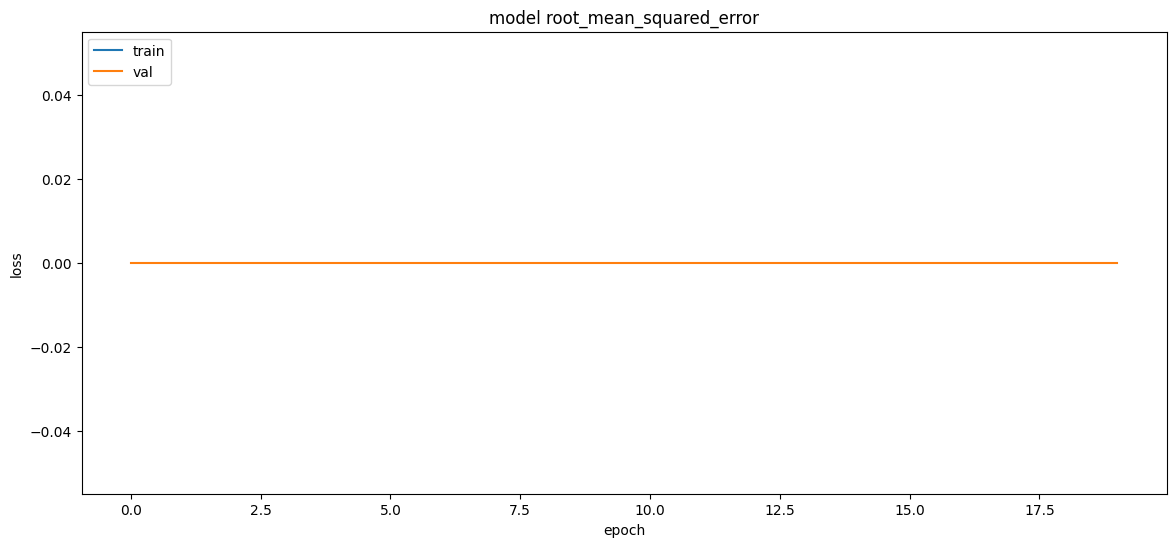

In [ ]:
#1st plot the history performance scores
plt.figure(figsize=(14,6))
plt.plot(cnn_unfrozen_transfer_history.history[list(cnn_unfrozen_transfer_history.history.keys())[0]])
plt.plot(cnn_unfrozen_transfer_history.history[list(cnn_unfrozen_transfer_history.history.keys())[2]])
plt.title('model root_mean_squared_error')
plt.ylabel(list(cnn_unfrozen_transfer_history.history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for train set
y_train_predictedCNN_unfrozen_transfer = cnn_transfer_model.predict(x_train)

1875/1875 [==============================] - 4s 2ms/step


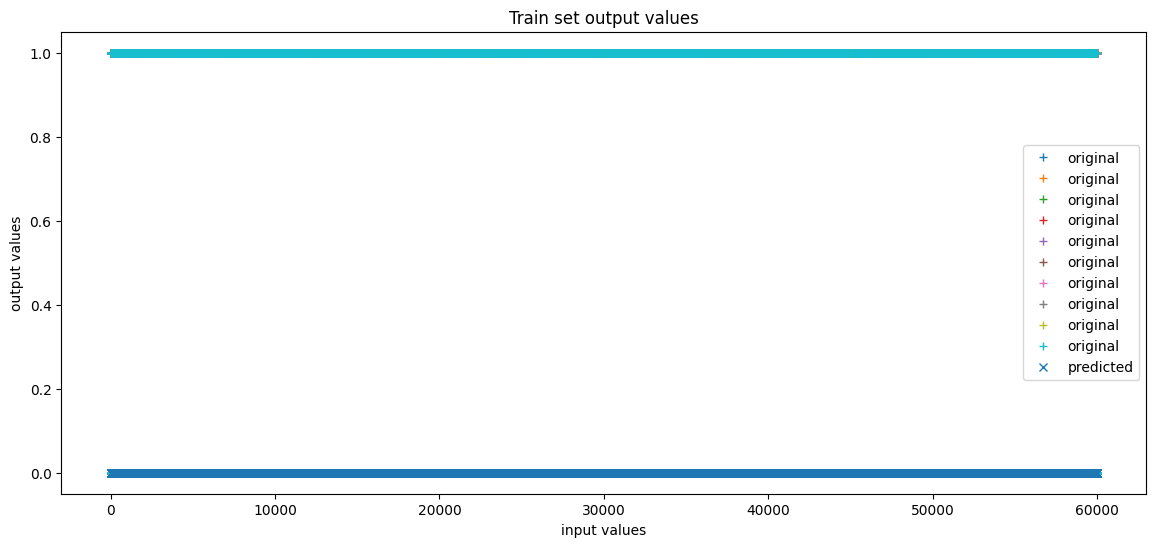

In [ ]:
y_train_predictedCNN_unfrozen_transfer = np.argmax(y_train_predictedCNN_unfrozen_transfer, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_train, '+', label='original')
plt.plot( y_train_predictedCNN_unfrozen_transfer, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#use the trained model to calculate the outputs for test set
y_test_predictedCNN_unfrozen_transfer = cnn_transfer_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


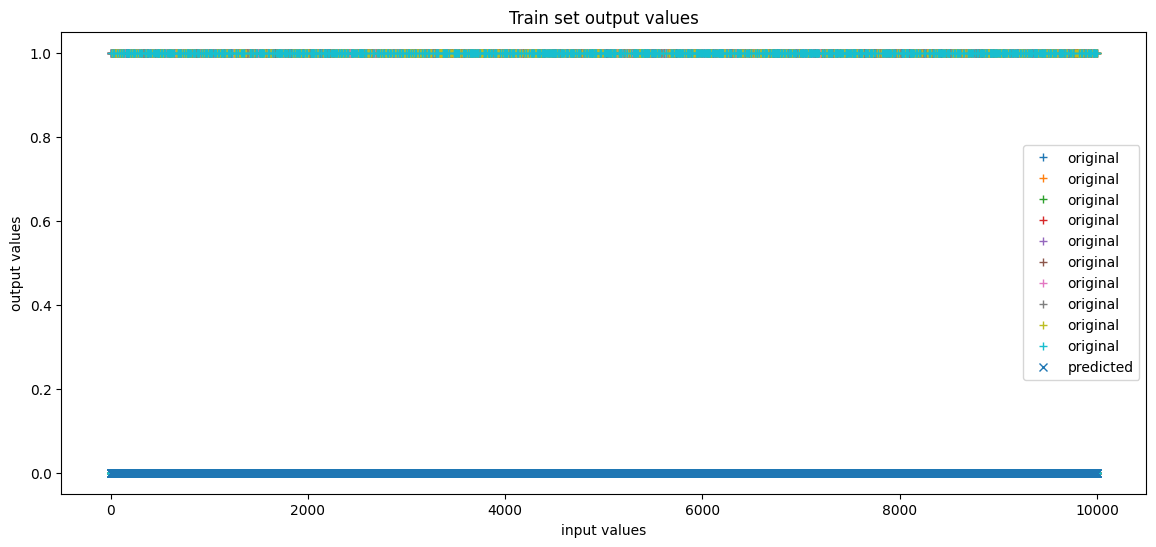

In [ ]:
y_test_predictedCNN_unfrozen_transfer = np.argmax(y_test_predictedCNN_unfrozen_transfer, axis=1)
plt.figure(figsize=(14,6))
plt.plot( y_test, '+', label='original')
plt.plot( y_test_predictedCNN_unfrozen_transfer, 'x', label='predicted')
plt.title('Train set output values')
plt.xlabel('input values')
plt.ylabel('output values')
plt.legend(loc='best')
plt.show()

In [ ]:
#predictions on train
y_train_predictedCNN_unfrozen_transfer = to_categorical(y_train_predictedCNN_unfrozen_transfer)

accuracy = accuracy_score(y_train, y_train_predictedCNN_unfrozen_transfer)
recall = recall_score(y_train, y_train_predictedCNN_unfrozen_transfer, average='macro')
precision = precision_score (y_train, y_train_predictedCNN_unfrozen_transfer, average='macro')
auc = roc_auc_score(y_train, y_train_predictedCNN_unfrozen_transfer)
f1= F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy, " recall:", recall, "precision:", precision, "auc:",auc, "f1:", f1 )

ValueError: ignored

In [ ]:
#Predictions on test
y_test_predictedCNN_unfrozen_transfer = to_categorical(y_test_predictedCNN_unfrozen_transfer)

accuracy_cnn_test = accuracy_score(y_test, y_test_predictedCNN_unfrozen_transfer)
recall_cnn_test = recall_score(y_test, y_test_predictedCNN_unfrozen_transfer, average='macro')
precision_cnn_test = precision_score (y_test, y_test_predictedCNN_unfrozen_transfer, average='macro')
auc_cnn_test = roc_auc_score(y_test, y_test_predictedCNN_unfrozen_transfer)
f1_cnn_test = F1Score(precision, recall)

print("The scores for the predicted outputs are : accuracy:", accuracy_cnn_test, " recall:", recall_cnn_test, "precision:", precision_cnn_test, "auc:",auc_cnn_test, "f1:", f1_cnn_test )

In [ ]:
# -------------------------------------------------------------|
#----------------- ONLY FOR TESTING THE CODE ------------------|
# -------------------------------------------------------------|

# results_acc.clear()
# results_pre.clear()
# results_rec.clear()
# results_f1.clear()
# techniques.clear()
# Set.clear()
# fold.clear()

In [ ]:
dict = {'Technique name [DNN/CNN]':techniques,'Set [Train/Test]':Set,\
        'Fold number [1, .., 6]':fold,'Accuracy':results_acc,\
        'Precision':results_pre,'Recall':results_rec,'F1 score':results_f1}
dfNew = pd.DataFrame(dict)

In [ ]:
# The dataframe salvation
path = '/content/drive/My Drive/erotima2.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  dfNew.to_csv(f, index = False)